In [1]:
import os
import pandas as pd
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import datetime
from scipy.interpolate import interp1d
import seaborn as sns

from utils import windpower_simulation_era5

In [2]:
from dask.diagnostics import ProgressBar
ProgressBar().register()

In [3]:
usa_path = "C:/Users/KatharinaG/Documents/USA"

In [4]:
col_refuel7 = sns.color_palette(["#c72321","#861719","#f0c320","#af8f19","#6e9b9e","#0d8085","#19484c"])
col_refuel3 = sns.color_palette(["#c72321", "#0d8085", "#efc220"])
col_refuel5 = sns.color_palette(["#c62220", "#fbd7a8", "#7a6952", "#0d8085", "#f0c220"])
col_refuel10 = sns.color_palette(["#c72321","#861719","#fbd7a9","#ba9f7c","#7a6952","#6e9b9e","#0d8085","#19484c","#f0c320","#af8f19"])


In [ ]:
rea_path = "C:/Users/KatharinaG/Data/era5/USA"

chk = {
    "time" : 38
}
data = xr.open_mfdataset(rea_path+"/*.nc",chunks=chk)

load locations of wind power plants

In [6]:
windturbines = pd.read_csv(usa_path+"/windturbines_usa.csv",delimiter=';') 

### Inspect windpark data

#### Capacities

In [7]:
# share of missing capacities
np.isnan(windturbines.t_cap).sum()/len(windturbines.t_cap)

0.05820890491759075

5.8 % of capacities missing - how is the distribution of capacities?

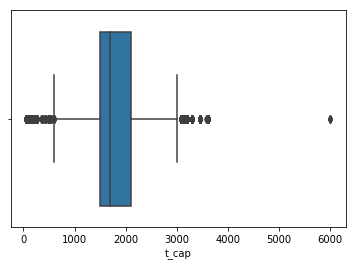

In [8]:
sns.boxplot(windturbines.t_cap)

C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


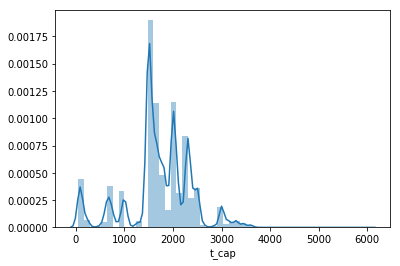

In [9]:
sns.distplot(windturbines.t_cap[~np.isnan(windturbines.t_cap)])

There are peaks at 1500 and 2000 kW

In [10]:
windturbines.t_cap.mean()

1718.1867081812325

Mean capacity is 1718 - set to 1700 for missing values

#### Commissioning year

In [11]:
# share of missing commissioning years
np.isnan(windturbines.p_year).sum()/len(windturbines.p_year)

0.001061714247194041

In [12]:
# share of capacity impacted
sum(windturbines.t_cap.fillna(1700)[np.isnan(windturbines.p_year.values)])/sum(windturbines.t_cap.fillna(1700))

0.0010952886824703739

0.1% of commissioning dates missing and also capacity impacted

#### Locations

In [13]:
# share of missing longitudes
np.isnan(windturbines.xlong).sum()/len(windturbines.xlong)

0.0

In [14]:
# share of missing latitudes
np.isnan(windturbines.ylat).sum()/len(windturbines.ylat)

0.0

No locations missing

#### Turbine heights

In [15]:
# share of missing turbine heights
np.isnan(windturbines.t_hh).sum()/len(windturbines.t_hh)

0.09373420068084533

9.4% missing

C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


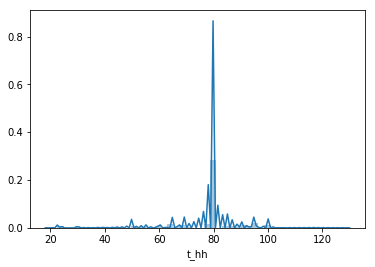

In [16]:
sns.distplot(windturbines.t_hh[~np.isnan(windturbines.t_hh)])

In [17]:
windturbines.t_hh.mean()

78.08781984528295

80m is most frequent and is close to mean

#### states

In [18]:
# share of missing states
pd.isnull(windturbines.t_state).sum()/len(windturbines.t_state)

0.0

### Fill in missing data

In [19]:
# 0.1% of years are missing, so set them mean of commissioning years
y = windturbines.p_year.fillna(windturbines.p_year.mean())

In [20]:
# capacities
cap = windturbines.t_cap.fillna(1700)

In [21]:
# hub heights
hh = windturbines.t_hh.fillna(80)

make commissioning dates - only years given so use middle of year

In [22]:
t = [np.datetime64(str(int(year))+"-06-01T00:00:00") for year in y]

In [23]:
# join data making a multiindex with time and state
time_state = tuples = tuple(zip(list(windturbines.t_state),t))
mi = pd.MultiIndex.from_tuples(time_state, names=['state', 'time'])
turbine_data = pd.DataFrame({'capacity':cap.values,
                             'height':hh.values,
                             'lon':windturbines.xlong.values,
                             'lat':windturbines.ylat.values,
                             'ind':range(len(cap))},index = mi)

In [24]:
turbine_data.head()

capacity  height         lon        lat  ind
state time                                                    
CA    1987-06-01      95.0    80.0 -118.358871  35.084488    0
      1987-06-01      95.0    80.0 -118.365677  35.078026    1
      1987-06-01      95.0    80.0 -118.352242  35.088539    2
      1987-06-01      95.0    80.0 -118.365860  35.077789    3
      1987-06-01      95.0    80.0 -118.352470  35.088196    4

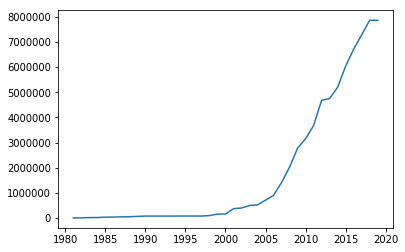

In [25]:
plt.plot(windturbines.groupby(windturbines.p_year).sum().p_cap.cumsum())

# Simulate wind power per state

In [ ]:
for state in turbine_data.index.levels[0].values:
    print(state)
    ind = turbine_data.xs(state).ind.values
    wps = windpower_simulation_era5(data,
                                    turbine_data.height[ind].values,
                                    turbine_data.capacity[ind].values,
                                    turbine_data.lon[ind].values,
                                    turbine_data.lat[ind].values,
                                    turbine_data.iloc[ind].index.get_level_values(level=1).values)
    # save as netcdf
    wps.to_dataset(name='wp').to_netcdf(usa_path+"/results/windpower_"+state+"_ERA5.nc")

# Simulate wind power per state with GWA

In [ ]:
GWA = xr.open_rasterio(usa_path+'/GWA/GWA_USA100m.tif')

In [ ]:
for state in turbine_data.index.levels[0].values:
    print(state)
    ind = turbine_data.xs(state).ind.values
    wps = windpower_simulation_era5(data,
                                    turbine_data.height[ind].values,
                                    turbine_data.capacity[ind].values,
                                    turbine_data.lon[ind].values,
                                    turbine_data.lat[ind].values,
                                    turbine_data.iloc[ind].index.get_level_values(level=1).values,
                                    GWA)
    # save as netcdf
    wps.to_dataset(name='wp').to_netcdf(usa_path+"/results/windpower_"+state+"_ERA5_GWA.nc")

# Sum up regions

## States

In [ ]:
for STATE in turbine_data.index.levels[0].values:
    wp_loc = xr.open_dataset(usa_path+"/results/windpower_"+STATE+"_ERA5.nc")
    wp_state = wp_loc.sum('location')
    if 'wp' in locals():
        wp = xr.concat([wp,wp_state.expand_dims(state=[STATE])],dim='state')
    else:
        wp = wp_state.expand_dims(state=[STATE])
    
# save as netcdf
wp.to_netcdf(usa_path+"/results/windpower_states_ERA5.nc")
del(wp)

In [ ]:
for STATE in turbine_data.index.levels[0].values:
    wp_loc = xr.open_dataset(usa_path+"/results/windpower_"+STATE+"_ERA5_GWA.nc")
    wp_state = wp_loc.sum('location')
    if 'wp' in locals():
        wp = xr.concat([wp,wp_state.expand_dims(state=[STATE])],dim='state')
    else:
        wp = wp_state.expand_dims(state=[STATE])
    
# save as netcdf
wp.to_netcdf(usa_path+"/results/windpower_states_ERA5_GWA.nc")
del(wp)

## BPA

In [ ]:
# load BPA wind parks
BPA_parks = pd.read_csv(usa_path+"/BPA_windparks.csv")
# add wind park names to turbine data
turbine_data['name'] = windturbines.p_name.values
for state in BPA_parks.state.unique():
    # load data of BPA states
    wp_loc = xr.open_dataset(usa_path+"/results/windpower_"+state+"_ERA5.nc")
    # get indices of BPA parks
    ind = [park in BPA_parks.name[BPA_parks.state==state].values for park in turbine_data.xs(state).name.values]
    # select BPA parks and sum up
    wp_state = wp_loc.isel(location=ind).sum('location')
    if 'wp' in locals():
        wp = xr.concat([wp,wp_state.expand_dims(state=[state])],dim='state')
    else:
        wp = wp_state.expand_dims(state=[state])
# sum over states
wpBPA = wp.sum('state')
# save as netcdf
wpBPA.to_netcdf(usa_path+"/results/windpower_BPA_ERA5.nc")
del(wp)

In [ ]:
# load BPA wind parks
BPA_parks = pd.read_csv(usa_path+"/BPA_windparks.csv")
# add wind park names to turbine data
turbine_data['name'] = windturbines.p_name.values
for state in BPA_parks.state.unique():
    # load data of BPA states
    wp_loc = xr.open_dataset(usa_path+"/results/windpower_"+state+"_ERA5_GWA.nc")
    # get indices of BPA parks
    ind = [park in BPA_parks.name[BPA_parks.state==state].values for park in turbine_data.xs(state).name.values]
    # select BPA parks and sum up
    wp_state = wp_loc.isel(location=ind).sum('location')
    if 'wp' in locals():
        wp = xr.concat([wp,wp_state.expand_dims(state=[state])],dim='state')
    else:
        wp = wp_state.expand_dims(state=[state])
# sum over states
wpBPA = wp.sum('state')
# save as netcdf
wpBPA.to_netcdf(usa_path+"/results/windpower_BPA_ERA5_GWA.nc")

## New England
New England is a part of the USA consisting of the states Connecticut, New Hampshire, Maine, Massachusetts, Rhode Island and Vermont (CT, NH, ME, MA, RI, VT)

In [32]:
NE_states = ['CT','NH','ME','MA','RI','VT']
# without GWA
wp_state = xr.open_dataset(usa_path+"/results/windpower_states_ERA5.nc")
wpNE = wp_state.sel(state=NE_states).sum('state')
wpNE.to_netcdf(usa_path+"/results/windpower_NewEngland_ERA5.nc")
# with GWA
wp_state = xr.open_dataset(usa_path+"/results/windpower_states_ERA5_GWA.nc")
wpNE = wp_state.sel(state=NE_states).sum('state')
wpNE.to_netcdf(usa_path+"/results/windpower_NewEngland_ERA5_GWA.nc")

## USA

In [4]:
# without GWA
wp_state = xr.open_dataset(usa_path+"/results/windpower_states_ERA5.nc")
wpUSA = wp_state.sum('state')
wpUSA.to_netcdf(usa_path+"/results/windpower_USA_ERA5.nc")
# with GWA
wp_state = xr.open_dataset(usa_path+"/results/windpower_states_ERA5_GWA.nc")
wpUSA = wp_state.sum('state')
wpUSA.to_netcdf(usa_path+"/results/windpower_USA_ERA5_GWA.nc")

# Analysis

## USA

### Load production data
Source: https://www.eia.gov/electricity/data/browser/#/topic/0?agg=1,0,2&fuel=008&geo=vvvvvvvvvvvvo&sec=o3g&linechart=ELEC.GEN.WND-US-99.M~ELEC.GEN.WND-IA-99.M~ELEC.GEN.WND-TX-99.M&columnchart=ELEC.GEN.WND-US-99.M~ELEC.GEN.WND-IA-99.M~ELEC.GEN.WND-TX-99.M&map=ELEC.GEN.WND-US-99.M&freq=M&start=200101&end=201809&ctype=linechart&ltype=pin&rtype=s&maptype=0&rse=0&pin=

In [31]:
prod_USAm = pd.read_csv(usa_path+"/generation_data/USA_monthly/Net_generation_wind_all_sectors_monthly.csv",header=4)

rename columns

In [39]:
prod_USAm.columns = ['time','wp_obs']

sort indices

In [47]:
prod_USAm = prod_USAm[~np.isnan(prod_USAm.wp_obs)].sort_index(axis=0 ,ascending=False)

create datetime index

In [60]:
months = pd.DataFrame({'month':range(1,13)},
                       index = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])

prod_USAm['month'] = pd.Series([t[:3] for t in prod_USAm.time]).map(months.month).values
prod_USAm['year'] = [t[-4:] for t in prod_USAm.time]

prod_USAm = prod_USAm.set_index(pd.Index([np.datetime64(str(int(prod_USAm.year.values[i]))+"-"+f"{prod_USAm.month.values[i]:02d}"+"-01T00:00:00") for i in range(len(prod_USAm))])).drop(['time','month','year'],axis=1)

In [117]:
wp_USA = xr.open_dataset(usa_path+"/results/windpower_USA_ERA5.nc")

In [121]:
wp_USA.wp.groupby(wp_USA.time)

array([], dtype=float64)

In [127]:
wp_USA.time[:10].values

array(['2000-12-01T00:00:00.000000000', '2000-12-01T01:00:00.000000000',
       '2000-12-01T02:00:00.000000000', '2000-12-01T03:00:00.000000000',
       '2000-12-01T04:00:00.000000000', '2000-12-01T05:00:00.000000000',
       '2000-12-01T06:00:00.000000000', '2000-12-01T07:00:00.000000000',
       '2000-12-01T08:00:00.000000000', '2000-12-01T09:00:00.000000000'],
      dtype='datetime64[ns]')

# Load production data

In [ ]:
# Load data Eastern Cape
data_ec = []
for year in range(2014,2019):
    datay = pd.read_csv(south_africa_path+"/production/EasternCape/Hourly_Electricity_production_[Load_Factor_[[%]]_data"+str(year)+".csv",delimiter=';') 
    if(len(data_ec)):
        data_ec = pd.concat([data_ec,datay])
    else:
        data_ec = datay

# Load data Western Cape
data_wc = []
for year in range(2015,2019):
    datay = pd.read_csv(south_africa_path+"/production/WesternCape/Hourly_Electricity_production_[Load_Factor_[[%]]_data"+str(year)+".csv",delimiter=';') 
    if(len(data_wc)):
        data_wc = pd.concat([data_wc,datay])
    else:
        data_wc = datay
        
# Load data Northern Cape
data_nc = []
for year in range(2017,2019):
    datay = pd.read_csv(south_africa_path+"/production/NorthernCape/Hourly_Electricity_production_[Load_Factor_[[%]]_data"+str(year)+".csv",delimiter=';') 
    if(len(data_nc)):
        data_nc = pd.concat([data_nc,datay])
    else:
        data_nc = datay

create pandas dataframes for each of the locations

In [ ]:
# Eastern Cape
y = np.array([data_ec['Settlement DateTime'].iloc[x][6:10] for x in range(data_ec.shape[0])])
m = np.array([data_ec['Settlement DateTime'].iloc[x][3:5] for x in range(data_ec.shape[0])])
d = np.array([data_ec['Settlement DateTime'].iloc[x][:2] for x in range(data_ec.shape[0])])
h = np.array([data_ec['Settlement DateTime'].iloc[x][11:13] for x in range(data_ec.shape[0])])
t1 = [np.datetime64(y[i]+'-'+m[i]+'-'+d[i]+"T"+h[i]+":00:00") for i in np.arange(len(y))]
# create dataframe with datetime index and simulated data and create column to fill in historical data
production_MW_ec = pd.DataFrame({'wp_MWh':data_ec['Production MWh'].tolist(),
                                 'sim_wp_MWh':np.nan,
                                 'sim_wp_MWh_GWA':np.nan},index=t1)

# Western Cape
y = np.array([data_wc['Settlement DateTime'].iloc[x][6:10] for x in range(data_wc.shape[0])])
m = np.array([data_wc['Settlement DateTime'].iloc[x][3:5] for x in range(data_wc.shape[0])])
d = np.array([data_wc['Settlement DateTime'].iloc[x][:2] for x in range(data_wc.shape[0])])
h = np.array([data_wc['Settlement DateTime'].iloc[x][11:13] for x in range(data_wc.shape[0])])
t1 = [np.datetime64(y[i]+'-'+m[i]+'-'+d[i]+"T"+h[i]+":00:00") for i in np.arange(len(y))]
# create dataframe with datetime index and simulated data and create column to fill in historical data
production_MW_wc = pd.DataFrame({'wp_MWh':data_wc['Production MWh'].tolist(),
                                 'sim_wp_MWh':np.nan,
                                 'sim_wp_MWh_GWA':np.nan},index=t1)

# Northern Cape
y = np.array([data_nc['Settlement DateTime'].iloc[x][6:10] for x in range(data_nc.shape[0])])
m = np.array([data_nc['Settlement DateTime'].iloc[x][3:5] for x in range(data_nc.shape[0])])
d = np.array([data_nc['Settlement DateTime'].iloc[x][:2] for x in range(data_nc.shape[0])])
h = np.array([data_nc['Settlement DateTime'].iloc[x][11:13] for x in range(data_nc.shape[0])])
t1 = [np.datetime64(y[i]+'-'+m[i]+'-'+d[i]+"T"+h[i]+":00:00") for i in np.arange(len(y))]
# create dataframe with datetime index and simulated data and create column to fill in historical data
production_MW_nc = pd.DataFrame({'wp_MWh':data_nc['Production MWh'].tolist(),
                                 'sim_wp_MWh':np.nan,
                                 'sim_wp_MWh_GWA':np.nan},index=t1)

# Fill in simulated data and sort

In [ ]:
# fill in simulated data - cannot be added simply as other column, as in historical data some time steps are missing
# therefore match simulated data to time steps
production_MW_ec.sim_wp_MWh = production_MW_ec.index.map(windpower_kW_area.Eastern_Cape)
production_MW_wc.sim_wp_MWh = production_MW_wc.index.map(windpower_kW_area.Western_Cape)
production_MW_nc.sim_wp_MWh = production_MW_nc.index.map(windpower_kW_area.Northern_Cape)

In [ ]:
# fill in GWA simulation
production_MW_ec.sim_wp_MWh_GWA = production_MW_ec.index.map(windpower_kW_area_GWA.Eastern_Cape)
production_MW_wc.sim_wp_MWh_GWA = production_MW_wc.index.map(windpower_kW_area_GWA.Western_Cape)
production_MW_nc.sim_wp_MWh_GWA = production_MW_nc.index.map(windpower_kW_area_GWA.Northern_Cape)


In [ ]:
# sort by datetime index
production_MW_ec = production_MW_ec.sort_index()
production_MW_wc = production_MW_wc.sort_index()
production_MW_nc = production_MW_nc.sort_index()

### Available data - incomplete historical generation

In [ ]:
available_data = pd.DataFrame({'EC':0,'NC':0,'WC':0,'ZAF':0},index=windpower_windparks.time.values)

In [ ]:
# fill in generation data
available_data.EC = np.invert([np.isnan(i) for i in available_data.index.map(production_MW_ec.sim_wp_MWh)]).astype(int)
available_data.NC = np.invert([np.isnan(i) for i in available_data.index.map(production_MW_nc.sim_wp_MWh)]).astype(int)
available_data.WC = np.invert([np.isnan(i) for i in available_data.index.map(production_MW_wc.sim_wp_MWh)]).astype(int)

In [ ]:
# for data availability in ZAF, we need to know in how many regions there was production at each time
producing_regions = pd.DataFrame({'EC':1,'NC':1,'WC':1,'ZAF':0},index=windpower_windparks.time.values)

In [ ]:
# set production 0 before recorded production
producing_regions.EC[producing_regions.index<production_MW_ec.index.min()] = 0
producing_regions.NC[producing_regions.index<production_MW_nc.index.min()] = 0
producing_regions.WC[producing_regions.index<production_MW_wc.index.min()] = 0

# producing regions in ZAF are sum of production in three regions
producing_regions.ZAF = producing_regions.EC + producing_regions.NC + producing_regions.WC
# set where no producing regions to -1
producing_regions.ZAF[producing_regions.ZAF==0] = -1

In [ ]:
available_data.ZAF = np.array([int(i==0) for i in (available_data.EC + available_data.NC + available_data.WC - producing_regions.ZAF)])

# Data selection - only use timespans where all data are available

In [ ]:
# only do for timespans where data are available for ALL regions (ZAF data available = 1)
production_MW_ec_ts = production_MW_ec[production_MW_ec.index.map(available_data.ZAF)==1]
production_MW_nc_ts = production_MW_nc[production_MW_nc.index.map(available_data.ZAF)==1]
production_MW_wc_ts = production_MW_wc[production_MW_wc.index.map(available_data.ZAF)==1]

In [ ]:
# prepare dataframe for summing up
production_MW_all = pd.DataFrame({'wp_MWh_EC':0, 'sim_wp_MWh_EC':0, 'sim_wp_MWh_EC_GWA':0,
                                  'wp_MWh_NC':0, 'sim_wp_MWh_NC':0, 'sim_wp_MWh_NC_GWA':0,
                                  'wp_MWh_WC':0, 'sim_wp_MWh_WC':0, 'sim_wp_MWh_WC_GWA':0},
                                  index = windpower_windparks.time.values[available_data.ZAF==1])
production_MW_all.wp_MWh_EC = production_MW_all.index.map(production_MW_ec_ts.wp_MWh)
production_MW_all.sim_wp_MWh_EC = production_MW_all.index.map(production_MW_ec_ts.sim_wp_MWh)
production_MW_all.sim_wp_MWh_EC_GWA = production_MW_all.index.map(production_MW_ec_ts.sim_wp_MWh_GWA)

production_MW_all.wp_MWh_NC = production_MW_all.index.map(production_MW_nc_ts.wp_MWh)
production_MW_all.sim_wp_MWh_NC = production_MW_all.index.map(production_MW_nc_ts.sim_wp_MWh)
production_MW_all.sim_wp_MWh_NC_GWA = production_MW_all.index.map(production_MW_nc_ts.sim_wp_MWh_GWA)

production_MW_all.wp_MWh_WC = production_MW_all.index.map(production_MW_wc_ts.wp_MWh)
production_MW_all.sim_wp_MWh_WC = production_MW_all.index.map(production_MW_wc_ts.sim_wp_MWh)
production_MW_all.sim_wp_MWh_WC_GWA = production_MW_all.index.map(production_MW_wc_ts.sim_wp_MWh_GWA)

In [ ]:
# fill nans with 0
production_MW_all = production_MW_all.fillna(0)

In [ ]:
# sum up for ZAF
production_MW_zaf_ts = pd.DataFrame({'wp_MWh':production_MW_all.wp_MWh_EC + production_MW_all.wp_MWh_NC + production_MW_all.wp_MWh_WC,
                                     'sim_wp_MWh':production_MW_all.sim_wp_MWh_EC + production_MW_all.sim_wp_MWh_NC + production_MW_all.sim_wp_MWh_WC,
                                     'sim_wp_MWh_GWA':production_MW_all.sim_wp_MWh_EC_GWA + production_MW_all.sim_wp_MWh_NC_GWA + production_MW_all.sim_wp_MWh_WC_GWA},
                                     index=production_MW_all.index)

# statistical analysis hourly

In [ ]:
# prepare dataframe for hourly statistical analysis
stats_h = pd.DataFrame({'cor':np.nan,
                        'rmse':np.nan,
                        'mbe':np.nan,
                        'avg':np.nan},
                        index = ['EC','EC_GWA','EC_obs',
                                 'NC','NC_GWA','NC_obs',
                                 'WC','WC_GWA','WC_obs',
                                 'ZAF','ZAF_GWA','ZAF_obs'])

Calculate correlations

In [ ]:
stats_h.cor = [np.corrcoef(production_MW_ec_ts.wp_MWh,production_MW_ec_ts.sim_wp_MWh)[0,1],
               np.corrcoef(production_MW_ec_ts.wp_MWh,production_MW_ec_ts.sim_wp_MWh_GWA)[0,1],
               np.nan,
               np.corrcoef(production_MW_wc_ts.wp_MWh,production_MW_wc_ts.sim_wp_MWh)[0,1],
               np.corrcoef(production_MW_wc_ts.wp_MWh,production_MW_wc_ts.sim_wp_MWh_GWA)[0,1],
               np.nan,
               np.corrcoef(production_MW_nc_ts.wp_MWh,production_MW_nc_ts.sim_wp_MWh)[0,1],
               np.corrcoef(production_MW_nc_ts.wp_MWh,production_MW_nc_ts.sim_wp_MWh_GWA)[0,1],
               np.nan,
               np.corrcoef(production_MW_zaf_ts.wp_MWh,production_MW_zaf_ts.sim_wp_MWh)[0,1],
               np.corrcoef(production_MW_zaf_ts.wp_MWh,production_MW_zaf_ts.sim_wp_MWh_GWA)[0,1],
               np.nan]


Calculate RMSEs

In [ ]:
stats_h.rmse = [np.sqrt(np.mean((np.array(production_MW_ec_ts.wp_MWh)-np.array(production_MW_ec_ts.sim_wp_MWh))**2)),
                 np.sqrt(np.mean((np.array(production_MW_ec_ts.wp_MWh)-np.array(production_MW_ec_ts.sim_wp_MWh_GWA))**2)),
                 np.nan,
                 np.sqrt(np.mean((np.array(production_MW_nc_ts.wp_MWh)-np.array(production_MW_nc_ts.sim_wp_MWh))**2)),
                 np.sqrt(np.mean((np.array(production_MW_nc_ts.wp_MWh)-np.array(production_MW_nc_ts.sim_wp_MWh_GWA))**2)),
                 np.nan,
                 np.sqrt(np.mean((np.array(production_MW_wc_ts.wp_MWh)-np.array(production_MW_wc_ts.sim_wp_MWh))**2)),
                 np.sqrt(np.mean((np.array(production_MW_wc_ts.wp_MWh)-np.array(production_MW_wc_ts.sim_wp_MWh_GWA))**2)),
                 np.nan,
                 np.sqrt(np.mean((np.array(production_MW_zaf_ts.wp_MWh)-np.array(production_MW_zaf_ts.sim_wp_MWh))**2)),
                 np.sqrt(np.mean((np.array(production_MW_zaf_ts.wp_MWh)-np.array(production_MW_zaf_ts.sim_wp_MWh_GWA))**2)),
                 np.nan]


Calculate MBEs

In [ ]:
stats_h.mbe = [(np.array(production_MW_ec_ts.sim_wp_MWh)-np.array(production_MW_ec_ts.wp_MWh)).mean(),
               (np.array(production_MW_ec_ts.sim_wp_MWh_GWA)-np.array(production_MW_ec_ts.wp_MWh)).mean(),
               np.nan,
               (np.array(production_MW_nc_ts.sim_wp_MWh)-np.array(production_MW_nc_ts.wp_MWh)).mean(),
               (np.array(production_MW_nc_ts.sim_wp_MWh_GWA)-np.array(production_MW_nc_ts.wp_MWh)).mean(),
               np.nan,
               (np.array(production_MW_wc_ts.sim_wp_MWh)-np.array(production_MW_wc_ts.wp_MWh)).mean(),
               (np.array(production_MW_wc_ts.sim_wp_MWh_GWA)-np.array(production_MW_wc_ts.wp_MWh)).mean(),
               np.nan,
               (np.array(production_MW_zaf_ts.sim_wp_MWh)-np.array(production_MW_zaf_ts.wp_MWh)).mean(),
               (np.array(production_MW_zaf_ts.sim_wp_MWh_GWA)-np.array(production_MW_zaf_ts.wp_MWh)).mean(),
               np.nan]


Calculate means

In [ ]:
stats_h.avg = [production_MW_ec_ts.sim_wp_MWh.mean(),production_MW_ec_ts.sim_wp_MWh_GWA.mean(),production_MW_ec_ts.wp_MWh.mean(),
               production_MW_nc_ts.sim_wp_MWh.mean(),production_MW_nc_ts.sim_wp_MWh_GWA.mean(),production_MW_nc_ts.wp_MWh.mean(),
               production_MW_wc_ts.sim_wp_MWh.mean(),production_MW_wc_ts.sim_wp_MWh_GWA.mean(),production_MW_wc_ts.wp_MWh.mean(),
               production_MW_zaf_ts.sim_wp_MWh.mean(),production_MW_zaf_ts.sim_wp_MWh_GWA.mean(),production_MW_zaf_ts.wp_MWh.mean()]


save dataframe with hourly results

In [ ]:
# hourly and absolute statistics
stats_ha = stats_h.transpose().set_index(pd.Index(['Correlation','RMSE_MWh','MBE_MWh','Mean_MWh']),'parameter')

In [ ]:
stats_ha.round(2)

In [ ]:
stats_ha.round(2).to_csv(south_africa_path+'/results/stats_h_abs_ERA5.csv',sep=';')

In [ ]:
# plot ZAF
prod_ZAFh = production_MW_zaf_ts.melt(var_name='type',value_name='hourly_MWh')
sns.set(style='darkgrid',context='talk')
plt.figure(figsize=(12,8))
ax = sns.boxplot(x='type',y='hourly_MWh',data=prod_ZAFh,palette=col_refuel3,linewidth=3)
#plt.ylim(0,1)
fig = ax.get_figure()
fig.savefig(south_africa_path+'/results/plots/absolute/ZAF_ERA5_hourly.png')

In [ ]:
# boxplots with seaborn for capes

# melt data for each region and add a region column
prod_ECh = production_MW_ec_ts.melt(var_name='type',value_name='hourly_MWh')
prod_ECh['region'] = 'EC'
prod_NCh = production_MW_nc_ts.melt(var_name='type',value_name='hourly_MWh')
prod_NCh['region'] = 'NC'
prod_WCh = production_MW_wc_ts.melt(var_name='type',value_name='hourly_MWh')
prod_WCh['region'] = 'WC'

# merge regions to one data frame
prod_Ch = pd.concat([prod_ECh,prod_NCh,prod_WCh])

In [ ]:
prod_Ch_tidy = prod_Ch.melt(id_vars=['region','type'],value_name='hourly_MWh').drop(columns={'variable'})

In [ ]:
CF_ZAFh = CF_ZAF_h.melt(var_name='type',value_name='hourly_CF')
sns.set(style='darkgrid',context='talk')
plt.figure(figsize=(12,8))
ax = sns.boxplot(x='region',y='hourly_MWh',hue='type',data=prod_Ch_tidy,palette=col_refuel3,linewidth=3)
#plt.ylim(0,1)
fig = ax.get_figure()
fig.savefig(south_africa_path+'/results/plots/absolute/regions_ERA5_hourly.png')

# statistical analysis daily

Whole country: need to remove days which are not complete, then aggregate daily

In [ ]:
# function which creates series of 0 and 1 when hours shall be kept (1, complete days with 24 hours)
# or hours shall be dropped (0, days where less than 24 hours are available)
def drop_less_one_day(datetimeindex):
    dt = np.array(datetimeindex.year*10000+datetimeindex.month*100+datetimeindex.day)
    length = np.unique(dt,return_counts=True)[1]
    
    filt = np.array([0]*len(length))
    filt[np.equal(length,24)] = 1
    code = np.repeat(filt,length)
    
    return code

In [ ]:
print('Shares of data kept')
d = drop_less_one_day(production_MW_ec_ts.index)
print("EC keep %: ", round(sum(np.equal(d,1))/len(production_MW_ec_ts.index)*100,1))

d = drop_less_one_day(production_MW_wc_ts.index)
print("WC keep %: ", round(sum(np.equal(d,1))/len(production_MW_wc_ts.index)*100,1))

d = drop_less_one_day(production_MW_nc_ts.index)
print("NC keep %: ", round(sum(np.equal(d,1))/len(production_MW_nc_ts.index)*100,1))

d = drop_less_one_day(production_MW_zaf_ts.index)
print("ZAF keep %: ", round(sum(np.equal(d,1))/len(production_MW_zaf_ts.index)*100,1))


In [ ]:
# first copy all the data, in order to avoid warning message
production_MW_ec_ts = production_MW_ec_ts.copy()
production_MW_nc_ts = production_MW_nc_ts.copy()
production_MW_wc_ts = production_MW_wc_ts.copy()
production_MW_zaf_ts = production_MW_zaf_ts.copy()

In [ ]:
# mark the data to keep
production_MW_ec_ts['keep'] = drop_less_one_day(production_MW_ec_ts.index)
production_MW_wc_ts['keep'] = drop_less_one_day(production_MW_wc_ts.index)
production_MW_nc_ts['keep'] = drop_less_one_day(production_MW_nc_ts.index)
production_MW_zaf_ts['keep'] = drop_less_one_day(production_MW_zaf_ts.index)

In [ ]:
# filter out only whole days
production_ec_filtered = production_MW_ec_ts[production_MW_ec_ts.keep==1]
production_wc_filtered = production_MW_wc_ts[production_MW_wc_ts.keep==1]
production_nc_filtered = production_MW_nc_ts[production_MW_nc_ts.keep==1]
production_zaf_filtered = production_MW_zaf_ts[production_MW_zaf_ts.keep==1]

### aggregate daily

In [ ]:
date_ec = production_ec_filtered.index.year*10000+production_ec_filtered.index.month*100 + production_ec_filtered.index.day
production_GW_EC_daily = production_ec_filtered.groupby(date_ec).sum()/1000
date_nc = production_nc_filtered.index.year*10000+production_nc_filtered.index.month*100 + production_nc_filtered.index.day
production_GW_NC_daily = production_nc_filtered.groupby(date_nc).sum()/1000
date_wc = production_wc_filtered.index.year*10000+production_wc_filtered.index.month*100 + production_wc_filtered.index.day
production_GW_WC_daily = production_wc_filtered.groupby(date_wc).sum()/1000
date_zaf = production_zaf_filtered.index.year*10000+production_zaf_filtered.index.month*100 + production_zaf_filtered.index.day
production_GW_ZAF_daily = production_zaf_filtered.groupby(date_zaf).sum()/1000

In [ ]:
production_GW_EC_daily = production_GW_EC_daily.drop('keep',axis=1).rename(columns={'wp_MWh':'obs','sim_wp_MWh':'sim','sim_wp_MWh_GWA':'sim_GWA'})
production_GW_NC_daily = production_GW_NC_daily.drop('keep',axis=1).rename(columns={'wp_MWh':'obs','sim_wp_MWh':'sim','sim_wp_MWh_GWA':'sim_GWA'})
production_GW_WC_daily = production_GW_WC_daily.drop('keep',axis=1).rename(columns={'wp_MWh':'obs','sim_wp_MWh':'sim','sim_wp_MWh_GWA':'sim_GWA'})
production_GW_ZAF_daily = production_GW_ZAF_daily.drop('keep',axis=1).rename(columns={'wp_MWh':'obs','sim_wp_MWh':'sim','sim_wp_MWh_GWA':'sim_GWA'})

### calculate statistical parameters
prepare dataframe for statistical parameters

In [ ]:
stats_d = pd.DataFrame({'cor':np.nan,
                        'rmse':np.nan,
                        'mbe':np.nan,
                        'avg':np.nan},
                        index = ['EC','EC_GWA','EC_obs',
                                 'NC','NC_GWA','NC_obs',
                                 'WC','WC_GWA','WC_obs',
                                 'ZAF','ZAF_GWA','ZAF_obs'])

Calculate correlations

In [ ]:
stats_d.cor = [np.corrcoef(production_GW_EC_daily.obs,production_GW_EC_daily.sim)[0,1],
               np.corrcoef(production_GW_EC_daily.obs,production_GW_EC_daily.sim_GWA)[0,1],
               np.nan,
               np.corrcoef(production_GW_WC_daily.obs,production_GW_WC_daily.sim)[0,1],
               np.corrcoef(production_GW_WC_daily.obs,production_GW_WC_daily.sim_GWA)[0,1],
               np.nan,
               np.corrcoef(production_GW_NC_daily.obs,production_GW_NC_daily.sim)[0,1],
               np.corrcoef(production_GW_NC_daily.obs,production_GW_NC_daily.sim_GWA)[0,1],
               np.nan,
               np.corrcoef(production_GW_ZAF_daily.obs,production_GW_ZAF_daily.sim)[0,1],
               np.corrcoef(production_GW_ZAF_daily.obs,production_GW_ZAF_daily.sim_GWA)[0,1],
               np.nan]


Calculate RMSEs

In [ ]:
stats_d.rmse = [np.sqrt(np.mean((np.array(production_GW_EC_daily.obs)-np.array(production_GW_EC_daily.sim))**2)),
                 np.sqrt(np.mean((np.array(production_GW_EC_daily.obs)-np.array(production_GW_EC_daily.sim_GWA))**2)),
                 np.nan,
                 np.sqrt(np.mean((np.array(production_GW_NC_daily.obs)-np.array(production_GW_NC_daily.sim))**2)),
                 np.sqrt(np.mean((np.array(production_GW_NC_daily.obs)-np.array(production_GW_NC_daily.sim_GWA))**2)),
                 np.nan,
                 np.sqrt(np.mean((np.array(production_GW_WC_daily.obs)-np.array(production_GW_WC_daily.sim))**2)),
                 np.sqrt(np.mean((np.array(production_GW_WC_daily.obs)-np.array(production_GW_WC_daily.sim_GWA))**2)),
                 np.nan,
                 np.sqrt(np.mean((np.array(production_GW_ZAF_daily.obs)-np.array(production_GW_ZAF_daily.sim))**2)),
                 np.sqrt(np.mean((np.array(production_GW_ZAF_daily.obs)-np.array(production_GW_ZAF_daily.sim_GWA))**2)),
                 np.nan]


Calculate MBEs

In [ ]:
stats_d.mbe = [(np.array(production_GW_EC_daily.sim)-np.array(production_GW_EC_daily.obs)).mean(),
               (np.array(production_GW_EC_daily.sim_GWA)-np.array(production_GW_EC_daily.obs)).mean(),
               np.nan,
               (np.array(production_GW_NC_daily.sim)-np.array(production_GW_NC_daily.obs)).mean(),
               (np.array(production_GW_NC_daily.sim_GWA)-np.array(production_GW_NC_daily.obs)).mean(),
               np.nan,
               (np.array(production_GW_WC_daily.sim)-np.array(production_GW_WC_daily.obs)).mean(),
               (np.array(production_GW_WC_daily.sim_GWA)-np.array(production_GW_WC_daily.obs)).mean(),
               np.nan,
               (np.array(production_GW_ZAF_daily.sim)-np.array(production_GW_ZAF_daily.obs)).mean(),
               (np.array(production_GW_ZAF_daily.sim_GWA)-np.array(production_GW_ZAF_daily.obs)).mean(),
               np.nan]


Calculate means

In [ ]:
stats_d.avg = [production_GW_EC_daily.sim.mean(),production_GW_EC_daily.sim_GWA.mean(),production_GW_EC_daily.obs.mean(),
               production_GW_NC_daily.sim.mean(),production_GW_NC_daily.sim_GWA.mean(),production_GW_NC_daily.obs.mean(),
               production_GW_WC_daily.sim.mean(),production_GW_WC_daily.sim_GWA.mean(),production_GW_WC_daily.obs.mean(),
               production_GW_ZAF_daily.sim.mean(),production_GW_ZAF_daily.sim_GWA.mean(),production_GW_ZAF_daily.obs.mean()]


save dataframe with daily results

In [ ]:
# hourly and absolute statistics
stats_da = stats_d.transpose().set_index(pd.Index(['Correlation','RMSE_MWh','MBE_MWh','Mean_MWh']),'parameter')

In [ ]:
stats_da.round(2).to_csv(south_africa_path+'/results/stats_d_abs_ERA5.csv',sep=';')

In [ ]:
stats_da.round(2)

boxplot for South Africa

In [ ]:
# plot South Africa
prod_ZAFd = production_GW_ZAF_daily.melt(var_name='type',value_name='daily_GWh')
sns.set(style='darkgrid',context='talk')
plt.figure(figsize=(12,8))
ax = sns.boxplot(x='type',y='daily_GWh',data=prod_ZAFd,palette=col_refuel3,linewidth=3)
fig = ax.get_figure()
fig.savefig(south_africa_path+'/results/plots/absolute/ZAF_ERA5_daily.png')

In [ ]:
# boxplots for capes

# melt data for each region and add a region column
prod_ECd = production_GW_EC_daily.melt(var_name='type',value_name='daily_GWh')
prod_ECd['region'] = 'EC'
prod_NCd = production_GW_NC_daily.melt(var_name='type',value_name='daily_GWh')
prod_NCd['region'] = 'NC'
prod_WCd = production_GW_WC_daily.melt(var_name='type',value_name='daily_GWh')
prod_WCd['region'] = 'WC'

# merge regions to one data frame
prod_Cd = pd.concat([prod_ECd,prod_NCd,prod_WCd])

In [ ]:
# lengths of time series
print('EC: '+str(prod_ECd.shape[0]))
print('NC: '+str(prod_NCd.shape[0]))
print('WC: '+str(prod_WCd.shape[0]))
print('ZAF: '+str(prod_ZAFd.shape[0]))

In [ ]:
prod_Cd_tidy = prod_Cd.melt(id_vars=['region','type'],value_name='daily_GWh').drop(columns={'variable'})

In [ ]:
# plot Capes
sns.set(style='darkgrid',context='talk')
plt.figure(figsize=(12,8))
ax = sns.boxplot(x='region',y='daily_GWh',hue='type',data=prod_Cd_tidy,palette=col_refuel3,linewidth=3)
fig = ax.get_figure()
fig.savefig(south_africa_path+'/results/plots/absolute/regions_ERA5_daily.png')

# Conclusion absolute analysis

always better with GWA, with GWA only slightly underestimated, without GWA more underestimation

In [ ]:
plt.plot(production_GW_ZAF_daily.iloc[:,:3].values)

# Installed Capacities

### make time series and get mean capacities

create time series of installed capacities

In [ ]:
# sort installed capacities by commissioning date
cap = pd.DataFrame({'capacity': list(windparks.Capacity),'region':list(windparks.Area)},index=t)
cap = cap.sort_index()

In [ ]:
# cumulative capacity EC
cap_ec = cap[cap.region=='Eastern Cape']
cap_ec = cap_ec.drop(columns={'region'}).groupby(cap_ec.index).sum()
cap_ec['capsum'] = cap_ec.capacity.cumsum()

In [ ]:
# cumulative capacity NC
cap_nc = cap[cap.region=='Northern Cape']
cap_nc = cap_nc.drop(columns={'region'}).groupby(cap_nc.index).sum()
cap_nc['capsum'] = cap_nc.capacity.cumsum()

In [ ]:
# cumulative capacity WC
cap_wc = cap[cap.region=='Western Cape']
cap_wc = cap_wc.drop(columns={'region'}).groupby(cap_wc.index).sum()
cap_wc['capsum'] = cap_wc.capacity.cumsum()

In [ ]:
plt.plot(cap_ec.capsum)
plt.plot(cap_nc.capsum)
plt.plot(cap_wc.capsum)
plt.legend(['EC','NC','WC'])

get first capacity in period of interest

In [ ]:
firstcap_ec = cap_ec[cap_ec.index<production_ec_filtered.index[0]].capsum[-1]
firstcap_nc = cap_nc[cap_nc.index<production_nc_filtered.index[0]].capsum[-1]
firstcap_wc = cap_wc[cap_wc.index<production_wc_filtered.index[0]].capsum[-1]

cut capacities after starting date of production

In [ ]:
capc_ec = cap_ec[(cap_ec.index>=production_ec_filtered.index[0])&(cap_ec.index<=production_ec_filtered.index[-1])]
capc_nc = cap_nc[(cap_nc.index>=production_nc_filtered.index[0])&(cap_nc.index<=production_nc_filtered.index[-1])]
capc_wc = cap_wc[(cap_wc.index>=production_wc_filtered.index[0])&(cap_wc.index<=production_wc_filtered.index[-1])]


Make dataframe with dates where all data are available as index to fill in capacities and then sum for ZAF

In [ ]:
cap_all_h = pd.DataFrame({'EC':0,'NC':0,'WC':0,'ZAF':0},index=available_data.index)

In [ ]:
# fill in cumulative capacities
cap_all_h.EC = cap_all_h.index.map(capc_ec.capsum)
cap_all_h.NC = cap_all_h.index.map(capc_nc.capsum)
cap_all_h.WC = cap_all_h.index.map(capc_wc.capsum)

In [ ]:
# fill in starting capacities at date of first observed generation
cap_all_h.at[production_MW_ec_ts.index[0],'EC'] = firstcap_ec
cap_all_h.at[production_MW_nc_ts.index[0],'NC'] = firstcap_nc
cap_all_h.at[production_MW_wc_ts.index[0],'WC'] = firstcap_wc

In [ ]:
# fill Nas with last capacity
cap_all_h = cap_all_h.fillna(method = 'ffill')

In [ ]:
# fill remaining Nas as beginning with 0
cap_all_h = cap_all_h.fillna(0)

In [ ]:
# sum up capacities for ZAF
cap_all_h.ZAF = cap_all_h[['EC','NC','WC']].sum(axis=1)

In [ ]:
plt.plot(cap_all_h)
plt.legend(cap_all_h.columns)

In [ ]:
# remove hours where not all data are available
cap_all_h = cap_all_h[available_data.ZAF==1]

In [ ]:
# mean capacities
mcap_zaf = cap_all_h.ZAF.mean()
mcap_ec = cap_all_h.EC[cap_all_h.EC>0].mean()
mcap_nc = cap_all_h.NC[cap_all_h.NC>0].mean()
mcap_wc = cap_all_h.WC[cap_all_h.WC>0].mean()

### Daily capacities

In [ ]:
# mark the data to keep
cap_all_h['keep'] = drop_less_one_day(cap_all_h.index)

In [ ]:
# filter out only whole days
cap_all_h_filtered = cap_all_h[cap_all_h.keep==1]

get daily time series

In [ ]:
date = cap_all_h_filtered.index.year*10000+cap_all_h_filtered.index.month*100 + cap_all_h_filtered.index.day
cap_all_d = cap_all_h_filtered.groupby(date).mean()

In [ ]:
cap_all_d = cap_all_d.drop('keep',axis=1)

In [ ]:
# mean capacities
mcap_zaf_d = cap_all_d.ZAF.mean()
mcap_ec_d = cap_all_d.EC[cap_all_d.EC>0].mean()
mcap_nc_d = cap_all_d.NC[cap_all_d.NC>0].mean()
mcap_wc_d = cap_all_d.WC[cap_all_d.WC>0].mean()

In [ ]:
plt.plot(production_MW_wc[production_MW_wc.index<=max(cap_all_h.index)])
plt.plot(cap_all_h.WC[cap_all_h.WC>0])
plt.legend(['obs','sim','sim_GWA','cap'])

In [ ]:
plt.plot(production_MW_nc[production_MW_nc.index<=max(cap_all_h.index)])
plt.plot(cap_all_h.NC[cap_all_h.NC>0])
plt.legend(['obs','sim','sim_GWA','cap'])

In [ ]:
plt.plot(production_MW_ec[production_MW_ec.index<=max(cap_all_h.index)])
plt.plot(cap_all_h.EC[cap_all_h.EC>0])
plt.legend(['obs','sim','sim_GWA','cap'])

# Relative results

### hourly

In [ ]:
stats_hr = stats_ha[['EC','EC_GWA','NC','NC_GWA','WC','WC_GWA','ZAF','ZAF_GWA']][:3].copy()

In [ ]:
stats_hr.iloc[1:,:2] = stats_ha.iloc[1:3,:2]/(mcap_ec)

stats_hr.iloc[1:,2:4] = stats_ha.iloc[1:3,3:5]/(mcap_nc)

stats_hr.iloc[1:,4:6] = stats_ha.iloc[1:3,6:8]/(mcap_wc)

stats_hr.iloc[1:,6:8] = stats_ha.iloc[1:3,9:11]/(mcap_zaf)

In [ ]:
stats_hr.round(2)

In [ ]:
# save relative results
stats_hr.round(2).to_csv(south_africa_path+"/results/stats_h_rel_ERA5.csv")

### daily

In [ ]:
stats_dr = stats_da[['EC','EC_GWA','NC','NC_GWA','WC','WC_GWA','ZAF','ZAF_GWA']][:3].copy()

In [ ]:
stats_dr.iloc[1:,:2] = stats_da.iloc[1:3,:2]/(mcap_ec_d*24/1000)

stats_dr.iloc[1:,2:4] = stats_da.iloc[1:3,3:5]/(mcap_nc_d*24/1000)

stats_dr.iloc[1:,4:6] = stats_da.iloc[1:3,6:8]/(mcap_wc_d*24/1000)

stats_dr.iloc[1:,6:8] = stats_da.iloc[1:3,9:11]/(mcap_zaf_d*24/1000)

In [ ]:
stats_dr.round(2)

In [ ]:
# save relative results
stats_dr.round(2).to_csv(south_africa_path+"/results/stats_d_rel_ERA5.csv")

# Capacity factors

let's also calculate daily and hourly capacity factors

### hourly

In [ ]:
CF_EC_h = production_MW_ec_ts.drop('keep',axis=1).div(cap_all_h.EC[cap_all_h.EC>0].values,axis=0)
CF_NC_h = production_MW_nc_ts.drop('keep',axis=1).div(cap_all_h.NC[cap_all_h.NC>0].values,axis=0)
CF_WC_h = production_MW_wc_ts.drop('keep',axis=1).div(cap_all_h.WC[cap_all_h.WC>0].values,axis=0)
CF_ZAF_h = production_MW_zaf_ts.drop('keep',axis=1).div(cap_all_h.ZAF[cap_all_h.ZAF>0].values,axis=0)

In [ ]:
plt.plot(CF_EC_h)

In [ ]:
plt.plot(CF_NC_h)

In [ ]:
plt.plot(CF_WC_h)

In [ ]:
plt.plot(CF_ZAF_h)

### daily

In [ ]:
CF_EC_d = production_GW_EC_daily.div(cap_all_d.EC[cap_all_d.EC>0].values*24/1000,axis=0)
CF_NC_d = production_GW_NC_daily.div(cap_all_d.NC[cap_all_d.NC>0].values*24/1000,axis=0)
CF_WC_d = production_GW_WC_daily.div(cap_all_d.WC[cap_all_d.WC>0].values*24/1000,axis=0)
CF_ZAF_d = production_GW_ZAF_daily.div(cap_all_d.ZAF[cap_all_d.ZAF>0].values*24/1000,axis=0)

In [ ]:
CF_EC_d.index = [np.datetime64(str(d)[:4]+'-'+str(d)[4:6]+'-'+str(d)[6:]) for d in CF_EC_d.index]
CF_NC_d.index = [np.datetime64(str(d)[:4]+'-'+str(d)[4:6]+'-'+str(d)[6:]) for d in CF_NC_d.index]
CF_WC_d.index = [np.datetime64(str(d)[:4]+'-'+str(d)[4:6]+'-'+str(d)[6:]) for d in CF_WC_d.index]
CF_ZAF_d.index = [np.datetime64(str(d)[:4]+'-'+str(d)[4:6]+'-'+str(d)[6:]) for d in CF_ZAF_d.index]

In [ ]:
plt.plot(CF_EC_d)

In [ ]:
plt.plot(CF_NC_d)

In [ ]:
plt.plot(CF_WC_d)

In [ ]:
plt.plot(CF_ZAF_d)

# Analysis Capacity Factors

### hourly

In [ ]:
statsCF_h = pd.DataFrame({'cor':np.nan,
                          'rmse':np.nan,
                          'mbe':np.nan,
                          'avg':np.nan},
                          index = ['EC','EC_GWA','EC_obs',
                                   'NC','NC_GWA','NC_obs',
                                   'WC','WC_GWA','WC_obs',
                                   'ZAF','ZAF_GWA','ZAF_obs'])

In [ ]:
CF_EC_h.columns =['obs','sim','sim_GWA']
CF_NC_h.columns =['obs','sim','sim_GWA']
CF_WC_h.columns =['obs','sim','sim_GWA']
CF_ZAF_h.columns =['obs','sim','sim_GWA']

In [ ]:
statsCF_h.cor = [np.corrcoef(CF_EC_h.obs,CF_EC_h.sim)[0,1],
                 np.corrcoef(CF_EC_h.obs,CF_EC_h.sim_GWA)[0,1],
                 np.nan,
                 np.corrcoef(CF_NC_h.obs,CF_NC_h.sim)[0,1],
                 np.corrcoef(CF_NC_h.obs,CF_NC_h.sim_GWA)[0,1],
                 np.nan,
                 np.corrcoef(CF_WC_h.obs,CF_WC_h.sim)[0,1],
                 np.corrcoef(CF_WC_h.obs,CF_WC_h.sim_GWA)[0,1],
                 np.nan,
                 np.corrcoef(CF_ZAF_h.obs,CF_ZAF_h.sim)[0,1],
                 np.corrcoef(CF_ZAF_h.obs,CF_ZAF_h.sim_GWA)[0,1],
                 np.nan]


In [ ]:
statsCF_h.rmse = [np.sqrt(np.mean((np.array(CF_EC_h.obs)-np.array(CF_EC_h.sim))**2)),
                  np.sqrt(np.mean((np.array(CF_EC_h.obs)-np.array(CF_EC_h.sim_GWA))**2)),
                  np.nan,
                  np.sqrt(np.mean((np.array(CF_NC_h.obs)-np.array(CF_NC_h.sim))**2)),
                  np.sqrt(np.mean((np.array(CF_NC_h.obs)-np.array(CF_NC_h.sim_GWA))**2)),
                  np.nan,
                  np.sqrt(np.mean((np.array(CF_WC_h.obs)-np.array(CF_WC_h.sim))**2)),
                  np.sqrt(np.mean((np.array(CF_WC_h.obs)-np.array(CF_WC_h.sim_GWA))**2)),
                  np.nan,
                  np.sqrt(np.mean((np.array(CF_ZAF_h.obs)-np.array(CF_ZAF_h.sim))**2)),
                  np.sqrt(np.mean((np.array(CF_ZAF_h.obs)-np.array(CF_ZAF_h.sim_GWA))**2)),
                  np.nan]

In [ ]:
statsCF_h.mbe = [(np.array(CF_EC_h.obs)-np.array(CF_EC_h.sim)).mean(),
                 (np.array(CF_EC_h.obs)-np.array(CF_EC_h.sim_GWA)).mean(),
                 np.nan,
                 (np.array(CF_NC_h.obs)-np.array(CF_NC_h.sim)).mean(),
                 (np.array(CF_NC_h.obs)-np.array(CF_NC_h.sim_GWA)).mean(),
                 np.nan,
                 (np.array(CF_WC_h.obs)-np.array(CF_WC_h.sim)).mean(),
                 (np.array(CF_WC_h.obs)-np.array(CF_WC_h.sim_GWA)).mean(),
                 np.nan,
                 (np.array(CF_ZAF_h.obs)-np.array(CF_ZAF_h.sim)).mean(),
                 (np.array(CF_ZAF_h.obs)-np.array(CF_ZAF_h.sim_GWA)).mean(),
                 np.nan]


In [ ]:
statsCF_h.avg = [CF_EC_h.sim.mean(),CF_EC_h.sim_GWA.mean(),CF_EC_h.obs.mean(),
                 CF_NC_h.sim.mean(),CF_NC_h.sim_GWA.mean(),CF_NC_h.obs.mean(),
                 CF_WC_h.sim.mean(),CF_WC_h.sim_GWA.mean(),CF_WC_h.obs.mean(),
                 CF_ZAF_h.sim.mean(),CF_ZAF_h.sim_GWA.mean(),CF_ZAF_h.obs.mean()]


save dataframe with hourly results

In [ ]:
# hourly and absolute statistics
statsCF_h = statsCF_h.transpose().set_index(pd.Index(['Correlation','RMSE_MWh','MBE_MWh','Mean_MWh']),'parameter')

In [ ]:
statsCF_h.round(2).to_csv(south_africa_path+'/results/statsCF_h_ERA5.csv',sep=';')

In [ ]:
statsCF_h.round(2)

boxplot for South Africa

In [ ]:
# plot South Africa
CF_ZAFh = CF_ZAF_h.melt(var_name='type',value_name='hourly_CF')
sns.set(style='darkgrid',context='talk')
plt.figure(figsize=(12,8))
ax = sns.boxplot(x='type',y='hourly_CF',data=CF_ZAFh,palette=col_refuel3,linewidth=3)
plt.ylim(0,1)
fig = ax.get_figure()
fig.savefig(south_africa_path+'/results/plots/CFs/ZAF_ERA5_hourly.png')

In [ ]:
# boxplots for capes

# melt data for each region and add a region column
CF_ECh = CF_EC_h.melt(var_name='type',value_name='hourly_CF')
CF_ECh['region'] = 'EC'
CF_NCh = CF_NC_h.melt(var_name='type',value_name='hourly_CF')
CF_NCh['region'] = 'NC'
CF_WCh = CF_WC_h.melt(var_name='type',value_name='hourly_CF')
CF_WCh['region'] = 'WC'

# merge regions to one data frame
CF_Ch = pd.concat([CF_ECh,CF_NCh,CF_WCh])

In [ ]:
# lengths of time series
print('EC: '+str(CF_ECh.shape[0]))
print('NC: '+str(CF_NCh.shape[0]))
print('WC: '+str(CF_WCh.shape[0]))
print('ZAF: '+str(CF_ZAFh.shape[0]))

In [ ]:
CF_Ch_tidy = CF_Ch.melt(id_vars=['region','type'],value_name='hourly_CF').drop(columns={'variable'})

In [ ]:
sns.set(style='darkgrid',context='talk')
plt.figure(figsize=(12,8))
ax = sns.boxplot(x='region',y='hourly_CF',hue='type',data=CF_Ch_tidy,palette=col_refuel3,linewidth=3)
ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))
plt.ylim(0,1)
fig = ax.get_figure()
fig.savefig(south_africa_path+'/results/plots/CFs/regions_ERA5_hourly.png')

### daily

In [ ]:
statsCF_d = pd.DataFrame({'cor':np.nan,
                          'rmse':np.nan,
                          'mbe':np.nan,
                          'avg':np.nan},
                          index = ['EC','EC_GWA','EC_obs',
                                   'NC','NC_GWA','NC_obs',
                                   'WC','WC_GWA','WC_obs',
                                   'ZAF','ZAF_GWA','ZAF_obs'])

In [ ]:
statsCF_d.cor = [np.corrcoef(CF_EC_d.obs,CF_EC_d.sim)[0,1],
                 np.corrcoef(CF_EC_d.obs,CF_EC_d.sim_GWA)[0,1],
                 np.nan,
                 np.corrcoef(CF_NC_d.obs,CF_NC_d.sim)[0,1],
                 np.corrcoef(CF_NC_d.obs,CF_NC_d.sim_GWA)[0,1],
                 np.nan,
                 np.corrcoef(CF_WC_d.obs,CF_WC_d.sim)[0,1],
                 np.corrcoef(CF_WC_d.obs,CF_WC_d.sim_GWA)[0,1],
                 np.nan,
                 np.corrcoef(CF_ZAF_d.obs,CF_ZAF_d.sim)[0,1],
                 np.corrcoef(CF_ZAF_d.obs,CF_ZAF_d.sim_GWA)[0,1],
                 np.nan]


In [ ]:
statsCF_d.rmse = [np.sqrt(np.mean((np.array(CF_EC_d.obs)-np.array(CF_EC_d.sim))**2)),
                  np.sqrt(np.mean((np.array(CF_EC_d.obs)-np.array(CF_EC_d.sim_GWA))**2)),
                  np.nan,
                  np.sqrt(np.mean((np.array(CF_NC_d.obs)-np.array(CF_NC_d.sim))**2)),
                  np.sqrt(np.mean((np.array(CF_NC_d.obs)-np.array(CF_NC_d.sim_GWA))**2)),
                  np.nan,
                  np.sqrt(np.mean((np.array(CF_WC_d.obs)-np.array(CF_WC_d.sim))**2)),
                  np.sqrt(np.mean((np.array(CF_WC_d.obs)-np.array(CF_WC_d.sim_GWA))**2)),
                  np.nan,
                  np.sqrt(np.mean((np.array(CF_ZAF_d.obs)-np.array(CF_ZAF_d.sim))**2)),
                  np.sqrt(np.mean((np.array(CF_ZAF_d.obs)-np.array(CF_ZAF_d.sim_GWA))**2)),
                  np.nan]

In [ ]:
statsCF_d.mbe = [(np.array(CF_EC_d.obs)-np.array(CF_EC_d.sim)).mean(),
                 (np.array(CF_EC_d.obs)-np.array(CF_EC_d.sim_GWA)).mean(),
                 np.nan,
                 (np.array(CF_NC_d.obs)-np.array(CF_NC_d.sim)).mean(),
                 (np.array(CF_NC_d.obs)-np.array(CF_NC_d.sim_GWA)).mean(),
                 np.nan,
                 (np.array(CF_WC_d.obs)-np.array(CF_WC_d.sim)).mean(),
                 (np.array(CF_WC_d.obs)-np.array(CF_WC_d.sim_GWA)).mean(),
                 np.nan,
                 (np.array(CF_ZAF_d.obs)-np.array(CF_ZAF_d.sim)).mean(),
                 (np.array(CF_ZAF_d.obs)-np.array(CF_ZAF_d.sim_GWA)).mean(),
                 np.nan]


In [ ]:
statsCF_d.avg = [CF_EC_d.sim.mean(),CF_EC_d.sim_GWA.mean(),CF_EC_d.obs.mean(),
                 CF_NC_d.sim.mean(),CF_NC_d.sim_GWA.mean(),CF_NC_d.obs.mean(),
                 CF_WC_d.sim.mean(),CF_WC_d.sim_GWA.mean(),CF_WC_d.obs.mean(),
                 CF_ZAF_d.sim.mean(),CF_ZAF_d.sim_GWA.mean(),CF_ZAF_d.obs.mean()]


save dataframe with daily results

In [ ]:
# hourly and absolute statistics
statsCF_d = statsCF_d.transpose().set_index(pd.Index(['Correlation','RMSE_MWh','MBE_MWh','Mean_MWh']),'parameter')

In [ ]:
statsCF_d.round(2).to_csv(south_africa_path+'/results/statsCF_d_ERA5.csv',sep=';')

In [ ]:
statsCF_d.round(2)

boxplot for South Africa

In [ ]:
# plot South Africa
CF_ZAFd = CF_ZAF_d.melt(var_name='type',value_name='daily_CF')
sns.set(style='darkgrid',context='talk')
plt.figure(figsize=(12,8))
ax = sns.boxplot(x='type',y='daily_CF',data=CF_ZAFd,palette=col_refuel3,linewidth=3)
plt.ylim(0,1)
fig = ax.get_figure()
fig.savefig(south_africa_path+'/results/plots/CFs/ZAF_ERA5_daily.png')

In [ ]:
# boxplots for capes

# melt data for each region and add a region column
CF_ECd = CF_EC_d.melt(var_name='type',value_name='daily_CF')
CF_ECd['region'] = 'EC'
CF_NCd = CF_NC_d.melt(var_name='type',value_name='daily_CF')
CF_NCd['region'] = 'NC'
CF_WCd = CF_WC_d.melt(var_name='type',value_name='daily_CF')
CF_WCd['region'] = 'WC'

# merge regions to one data frame
CF_Cd = pd.concat([CF_ECd,CF_NCd,CF_WCd])

In [ ]:
# lengths of time series
print('EC: '+str(CF_ECd.shape[0]))
print('NC: '+str(CF_NCd.shape[0]))
print('WC: '+str(CF_WCd.shape[0]))
print('ZAF: '+str(CF_ZAFd.shape[0]))

In [ ]:
CF_Cd_tidy = CF_Cd.melt(id_vars=['region','type'],value_name='daily_CF').drop(columns={'variable'})

In [ ]:
plt.figure(figsize=(12,8))
ax = sns.boxplot(x='region',y='daily_CF',hue='type',data=CF_Cd_tidy,palette=col_refuel3,linewidth=3)
ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))
plt.ylim(0,1)
fig = ax.get_figure()
fig.savefig(south_africa_path+'/results/plots/CFs/regions_ERA5_daily.png')